In [4]:
#loading the given dataset
import pandas as pd

df = pd.read_csv('/content/Churn_Modelling.csv')

In [5]:
df.head()
df.describe()
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


In [6]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)


In [7]:
from sklearn.model_selection import train_test_split

X = df.drop('Exited', axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [9]:
#We can use only one model but for better comparison of performance ,I have used both logistic regression and random forest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


log_reg = LogisticRegression(class_weight='balanced', random_state=42)
log_reg.fit(X_train, y_train)
y_pred_logreg = log_reg.predict(X_test)

print("==== Logistic Regression Results ====")
print(confusion_matrix(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_logreg))

print("\n--------------------------------------\n")


rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("==== Random Forest Results ====")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_rf))


==== Logistic Regression Results ====
[[1159  448]
 [ 113  280]]
              precision    recall  f1-score   support

           0       0.91      0.72      0.81      1607
           1       0.38      0.71      0.50       393

    accuracy                           0.72      2000
   macro avg       0.65      0.72      0.65      2000
weighted avg       0.81      0.72      0.75      2000

ROC AUC Score: 0.7168439286771774

--------------------------------------

==== Random Forest Results ====
[[1552   55]
 [ 213  180]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1607
           1       0.77      0.46      0.57       393

    accuracy                           0.87      2000
   macro avg       0.82      0.71      0.75      2000
weighted avg       0.86      0.87      0.85      2000

ROC AUC Score: 0.7118950013538099


In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}
random_search = RandomizedSearchCV(rf_clf, param_distributions=param_dist,
                                   n_iter=20, scoring='roc_auc',
                                   n_jobs=-1, cv=3, random_state=42)
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)
best_rf = random_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
print(confusion_matrix(y_test, y_pred_best_rf))
print(classification_report(y_test, y_pred_best_rf))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_best_rf))


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
18 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_

Best Parameters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10}
[[1407  200]
 [ 117  276]]
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      1607
           1       0.58      0.70      0.64       393

    accuracy                           0.84      2000
   macro avg       0.75      0.79      0.77      2000
weighted avg       0.86      0.84      0.85      2000

ROC AUC Score: 0.788917284589843


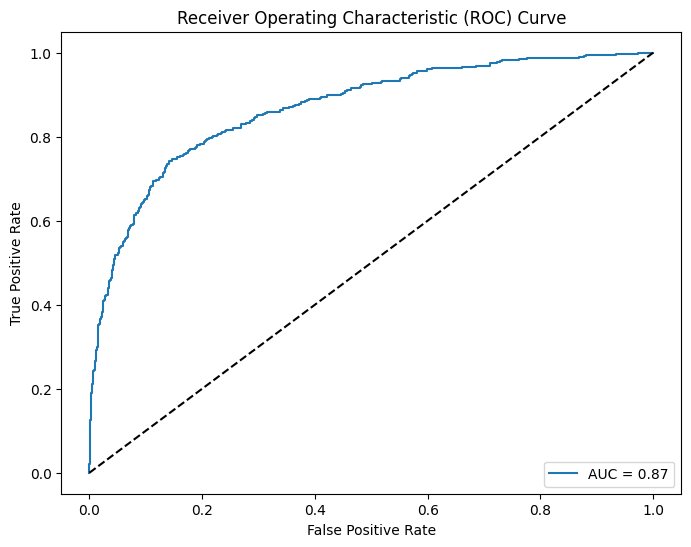

In [11]:
#find the roc curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_pred_proba = best_rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label="AUC = {:.2f}".format(roc_auc))
plt.plot([0,1],[0,1],'k--') # random predictions curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


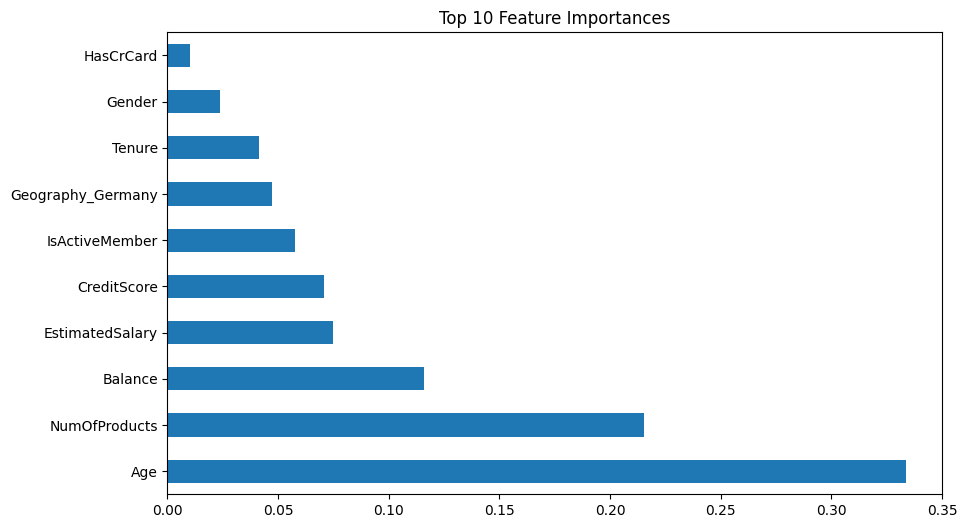

In [13]:
#feature importance
importances = best_rf.feature_importances_
feature_names = X.columns  # <-- use your original DataFrame's column names
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.nlargest(10).plot(kind='barh', figsize=(10,6))
plt.title('Top 10 Feature Importances')
plt.show()


In [14]:
#saving the trained model
import joblib
joblib.dump(best_rf, 'random_forest_churn_model.pkl')


['random_forest_churn_model.pkl']

In [ ]:
## Conclusion
#Final Model: Random Forest Classifier
# Accuracy: 84%
# ROC AUC: 0.79
# Important features contributing to churn: Age, Credit Score, Balance, IsActiveMember
# The model can help the company proactively identify customers at risk of churning.
